# Programming Assignment 6.2. Optimizing a reversible circuit

In this task, you'll optimize the given circuit - modify it so that its effect doesn't change (it still implements the same computation) and it requires as few resources to run as possible. See `evaluate_results` function for details on how your absolute score for the task is calculated.

In [21]:
pip install qsharp

Note: you may need to restart the kernel to use updated packages.


In [22]:
import qsharp

**The complete code for the task should be in this cell.**   
This cell can include additional open statements and helper operations and functions if your solution needs them. Your solution should not use measurements.

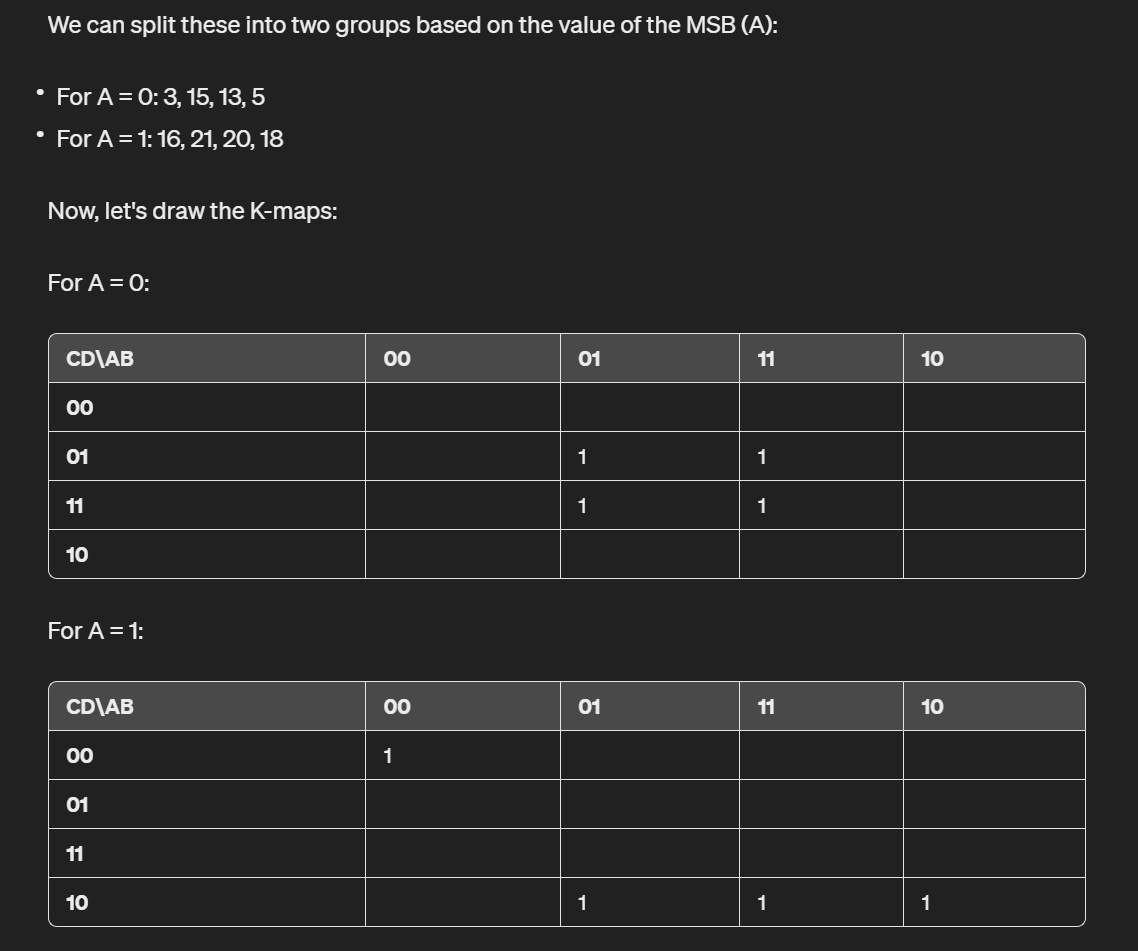

Combining these, the simplified Boolean expression for the given K-map is:

F(A, B, C, D, E) = B'C'D' + A'B'C'D'E + A'BC'D

In [49]:
%%qsharp
open Microsoft.Quantum.Canon;

// This circuit implements a marking oracle that marks the letters that comprise the word COMPUTER.
// The oracle uses little endian to convert integers that represent letters positions in the aphabet to bit strings.
// The input will contain exactly 5 qubits.
operation QuantumCircuit(input : Qubit[], target : Qubit) : Unit {
    // ApplyControlledOnInt( 3, X, input, target);  // C
    // ApplyControlledOnInt(15, X, input, target);  // O
    // ApplyControlledOnInt(13, X, input, target);  // M
    // ApplyControlledOnInt(16, X, input, target);  // P
    // ApplyControlledOnInt(21, X, input, target);  // U
    // ApplyControlledOnInt(20, X, input, target);  // T
    // ApplyControlledOnInt( 5, X, input, target);  // E
    // ApplyControlledOnInt(18, X, input, target);  // R
        // Apply the first term B'C'D'
        // Apply the first term BCDE
    // Allocate additional qubits for intermediate results
// mutable intermediate: Qubit[]= [];
 use (intermediate) = (Qubit[6]);

    // Apply the first term B'C'D'
    within {
        // No X gates needed for B'C'D'
    } apply {
        CCNOT(input[1], input[2], intermediate[0]);
        CCNOT(input[3], intermediate[0], target);
        X(target);
    }

    // Apply the second term A'B'C'D'E
    within {
        X(input[0]);
        X(input[1]);
        X(input[2]);
        X(input[3]);
    } apply {
        CCNOT(input[0], input[1], intermediate[1]);
        CCNOT(input[2], intermediate[1], intermediate[2]);
        CCNOT(input[3], intermediate[2], intermediate[3]);
        CCNOT(input[4], intermediate[3], target);
        X(target);
    }

    // Apply the third term A'BC'D
    within {
        X(input[0]);
        // No X gate needed for D
    } apply {
        CCNOT(input[0], input[1], intermediate[4]);
        CCNOT(input[2], intermediate[4], intermediate[5]);
        CCNOT(input[3], intermediate[5], target);
        X(target);
    }
}




In [50]:
%%qsharp
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Diagnostics;

// The operation that runs the oracle on every bit string and compares the results with those of a classical function
// (also checks that there are no measurements)
operation AssertOracleImplementsFunction (N : Int, oracle : ((Qubit[], Qubit) => Unit), f : (Bool[] -> Bool)) : Unit {
    let size = 1 <<< N;
    use (qs, target) = (Qubit[N], Qubit());
    for k in 0 .. size - 1 {
        // Prepare k-th bit vector
        let binary = IntAsBoolArray(k, N);
            
        //Message($"{k}/{N} = {binary}");
        // binary is little-endian notation, so the second vector tried has qubit 0 in state 1 and the rest in state 0
        ApplyPauliFromBitString(PauliX, true, binary, qs);
            
        // Apply the operation
        oracle(qs, target);
            
        // Check that the result is what we'd expect to measure
        let val = f(binary);
        if val {
            X(target);
        }
        if not CheckAllZero([target]) {
            fail $"Target in incorrect state for input {k} = {binary}";
        }

        // Check that the query qubits are still in the same state
        ApplyPauliFromBitString(PauliX, true, binary, qs);
        if not CheckAllZero(qs) {
            fail $"The state of control qubits changed for input {k} = {binary}";
        }
    }
}

// Check that the bitstring is one of the letters COMPUTER
function QuantumF(args : Bool[]) : Bool {
    let ascii = BoolArrayAsInt(args);
    return Any(letter -> letter == ascii, [3, 5, 13, 15, 16, 18, 20, 21]);
}

// Wrapper operation that allows to run the logical test for the task
operation TestWrapper() : Unit {
    let N = 5;
    AssertOracleImplementsFunction(N, QuantumCircuit, QuantumF);
    Message("Test passed!");
}

// Wrapper operation that allows to run resource estimation for the task.
// This operation only allocates the qubits and applies the oracle once, not using any additional gates or measurements.
operation ResourceEstimationWrapper() : Unit {
    let N = 5;
    use (input, target) = (Qubit[N], Qubit());
    QuantumCircuit(input, target);
}


Use the following cell to test your change to make sure it still performs the right computation. (You need to recompile the cell above every time you change your solution to test it.)
* If your solution is correct, the cell will report "Test passed!".
* Otherwise, it will throw an exception telling you on which basis state your solution is incorrect and in what way (either the function value is calculated incorrectly or the state of the control qubits changed).

In [51]:
qsharp.eval("TestWrapper()")


QSharpError: Error: Qubit67 released while not in |0⟩ state
Call stack:
    at QIR.Runtime.__quantum__rt__qubit_release in core/qir.qs
    at QIR.Runtime.ReleaseQubitArray in core/qir.qs
    at QuantumCircuit in line_38
    at AssertOracleImplementsFunction in line_39
    at TestWrapper in line_39
[31mQsc.Eval.ReleasedQubitNotZero[0m

  [31m×[0m runtime error
[31m  ╰─▶ [0mQubit67 released while not in |0⟩ state
    ╭─[[36;1;4mcore/qir.qs[0m:25:1]
 [2m25[0m │         for q in qs {
 [2m26[0m │             __quantum__rt__qubit_release(q);
    · [35;1m                                         ┬[0m
    ·                                          [35;1m╰── [35;1mQubit67[0m[0m
 [2m27[0m │         }
    ╰────
[36m  help: [0mqubits should be returned to the |0⟩ state before being released to
        satisfy the assumption that allocated qubits start in the |0⟩ state


Use the following cells to evaluate the resources required to run your solution.
* The score for the original code is 6048. 
* If your solution gets a score between 4500 and 6000, you'll get 1 point.
* If your solution gets a score between 2000 and 4500, you'll get 2 points.
* If your solution gets a score under 2000, you'll get 3 points.

In [7]:
result = qsharp.estimate("ResourceEstimationWrapper()")
# result

In [31]:
# The function that extracts the relevant resource information from the resource estimation job results and produces your absolute score.
def evaluate_results(res) : 
    width = res['physicalCounts']['breakdown']['algorithmicLogicalQubits']
    depth = res['physicalCounts']['breakdown']['algorithmicLogicalDepth']
    print(f"Logical algorithmic qubits = {width}")
    print(f"Algorithmic depth = {depth}")
    print(f"Score = {width * depth}")
    return width * depth


In [32]:
evaluate_results(result)

Logical algorithmic qubits = 28
Algorithmic depth = 216
Score = 6048


6048